In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation
from compute_dynamics import *
from Jacobian import jacobian_func

In [2]:
# import Particle Swarm Optimization algorithm
from PSO_algo import Particle
from PSO_algo import PSO

### Description
The number of pneumococcus serotypes reported in Denmark is $33$, and the ratio $I/D$ of single to co-colonization is $\mu = 10.23$. \
We need to estimate the matrix $33 \times 33$ $\left(\alpha_{ij}\right)$ of Denmark. Since $\mu$ of Denmark is large, we estimate parameters such that the data observation (Denmark serotype abundances) is the solution of the replicator dynamics at time $\tau=50$ with the same frequencies for all initial values $z_N(0)$, $1 \leq N \leq 33$. \
i) First, from $\alpha_{ij}$'s estimated from Nepal and Brazil, we insert as fixed the $\alpha_{ij}$'s values already estimated in two previous processes. \
ii) Then we apply the PSO algorithm in the range $\left[-10, 10\right]$ to estimate the remaining $305$ $\alpha_{ij}$'s such that the error between data observation $z^*_{\text{Denmark}}$ and the solution of replicator dynamics (corresponding to $\Lambda$ matrix calculated from $\left(\alpha_{ij}\right)$) at time $\tau=50$ $\mathbf{z}(50)$ attains as low value as possible. \
There are $305$ $\alpha_{ij}$'s estimated.

In [3]:
# data observation from 5 countries
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

# import name of serotypes and their frequencies from Denmark
strain_number = len(Denmark.strain) #33 strains
Denmark_strain = np.array(Denmark.strain)
Denmark_cases = np.array(Denmark.cases)

#ratio of single to co-colonization prevalence: mu value of Denmark
mu = 10.23

#import Nepal alpha & data
Nepal_alpha = np.loadtxt(open("Nepal_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Nepal_strain = np.array(Nepal.strain)

#import Brazil alpha & data
Brazil_alpha = np.loadtxt(open("Brazil_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Brazil_strain = np.array(Brazil.strain)

In [4]:
# initiate matrix Denmark_alpha
Denmark_alpha = np.ones((strain_number, strain_number))*50

#In Brazil alpha matrix, find the positions of alpha_ij already estimated before in Nepal, Brazil and fills with these values
for xD, strain_xD in enumerate(Denmark_strain):
    for yD, strain_yD in enumerate(Denmark_strain):
        #insert Nepal alphas
        find_xNepal = np.where(Nepal_strain == strain_xD)
        index_xNepal = find_xNepal[0]

        find_yNepal = np.where(Nepal_strain == strain_yD)
        index_yNepal = find_yNepal[0]

        #insert Brazil alphas
        find_xBrazil = np.where(Brazil_strain == strain_xD)
        index_xBrazil = find_xBrazil[0]

        find_yBrazil = np.where(Brazil_strain == strain_yD)
        index_yBrazil = find_yBrazil[0]

        if index_xBrazil.size > 0 and index_yBrazil.size > 0:
            Denmark_alpha[xD, yD] = Brazil_alpha[index_xBrazil, index_yBrazil]
        elif index_xNepal.size > 0 and index_yNepal.size > 0:
            Denmark_alpha[xD, yD] = Nepal_alpha[index_xNepal, index_yNepal]

np.savetxt('fix_alpha_Denmark.txt', Denmark_alpha, delimiter = ',')

In [5]:
#find the length of vector that we need to fit the matrix Denmark alpha
length = 0

for i in range(0, strain_number):
    for j in range(0, strain_number):
        if Denmark_alpha[i,j] > 49:
            length += 1

print(length)
#so we need to fit the matrix Denmark

305


In [6]:
#find the coordinate of missing alpha_ij in Denmark alpha_matrix
position = []

for i in range (0, strain_number):
    for j in range (0, strain_number):
        if Denmark_alpha[i,j] > 49:
            position.append(np.array([i,j]))

In [7]:
#initial value
u0 = (1/strain_number)*np.ones(strain_number)

#cost function for PSO
def func(vector):
    # insert alpha vector to Denmark_alpha
    alpha_matrix = np.loadtxt(open("fix_alpha_Denmark.txt","rb"), delimiter=",", skiprows = 0)

    for i in range (0, length):
        coordinate = position[i]
        alpha_matrix[coordinate[0], coordinate[1]] = vector[i]

    #compute invasion fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]

    # compute the predicted frequencies, i.e. the solution of replicator equations at t = 50
    solution = Replicator(strain_number, lambd, 50, u0)
    # compute the error between observation data and predictied prevalence
    err = np.linalg.norm(solution - Denmark_cases)

    return err

In [8]:
# RUN PSO algo

# initial starting location [x1,x2...]
initial = [0]*length
print(func(initial))

#time consuming 10h52

# input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
bounds = []
for i in range (0, length):
    bounds.append(np.array([-10, 10]))
bounds = np.array(bounds)

#run the algorithm
PSO(func, initial, bounds, num_particles = 1000, maxiter = 2000)

0.4493038905420381
FINAL:
[0.8648460275368542, -0.5570227141692478, -0.3268469638214156, -0.15614148928915944, -0.3911113297504605, 0.24860913801306161, 0.9622144343745944, -1.2133765925701783, -0.38392746191687865, -0.04749873620803188, 1.0664004483381435, 1.2939904816626726, 2.092856930312181, -1.1037124033624766, 0.3050996944937646, 1.036297227869674, -0.823612234407805, 2.9410292402666283, -0.576651641066966, 0.590725115455309, -0.5386362876331177, -0.9517036213191212, 4.124822759516636, -1.7161259599185472, -1.144296742017816, -0.4673156243167581, 1.393520816871183, -0.404396646150395, 0.364459431366155, 1.1199158183996916, 1.2155061317588285, 0.6920167765448836, -4.6119684918699315, -0.4908766658644573, 0.8345972430847427, 0.9288190810862631, -0.4196916818707502, 0.011106175230425638, 0.35769534431700484, 1.6383730507894156, -0.6955360443586784, -2.8379388369774277, 0.11043063095396347, -1.0212317292480502, -1.6676262248740072, 0.7535147535620687, -1.0349602879915627, 0.123932516

In [8]:
#the 305-vector predicted
opti_Denmark = [0.8648460275368542, -0.5570227141692478, -0.3268469638214156, -0.15614148928915944, -0.3911113297504605, 0.24860913801306161, 0.9622144343745944, -1.2133765925701783, -0.38392746191687865, -0.04749873620803188, 1.0664004483381435, 1.2939904816626726, 2.092856930312181, -1.1037124033624766, 0.3050996944937646, 1.036297227869674, -0.823612234407805, 2.9410292402666283, -0.576651641066966, 0.590725115455309, -0.5386362876331177, -0.9517036213191212, 4.124822759516636, -1.7161259599185472, -1.144296742017816, -0.4673156243167581, 1.393520816871183, -0.404396646150395, 0.364459431366155, 1.1199158183996916, 1.2155061317588285, 0.6920167765448836, -4.6119684918699315, -0.4908766658644573, 0.8345972430847427, 0.9288190810862631, -0.4196916818707502, 0.011106175230425638, 0.35769534431700484, 1.6383730507894156, -0.6955360443586784, -2.8379388369774277, 0.11043063095396347, -1.0212317292480502, -1.6676262248740072, 0.7535147535620687, -1.0349602879915627, 0.12393251689203029, 2.210772193304962, -0.7667420846758127, -0.6962222746595925, 1.0393823976037482, -0.5511414499686387, -0.27341296714915486, 1.2561545141034531, 2.6903950814057023, 1.4448832058762664, -0.6700786094386145, -1.9662455821221936, 1.763941757775225, 0.674994420806679, 1.1785251191113546, 2.0696921795518146, 1.0891614930193614, -1.8452152585052004, 4.558730124560938, -0.1623559283597754, 0.13797086013748905, -1.0901716400753771, -1.2049553619154556, 2.6761026301099844, 0.28641029035798254, 0.08029633253688039, -1.7071663116916993, -1.0259837788152386, 3.9324625068039634, 1.0061176440774597, 0.027591331761293084, 1.6042212781579033, -4.017194376642419, 0.029664678647447783, -1.109679216183812, -0.3631076932944363, -0.6109778688680082, -0.6525660064179769, 1.421039831637305, 1.5772341820006517, -0.3979816448510039, 1.942222503103525, 1.0449697634613189, -0.6721152225643435, 2.6116342373684973, 0.7769451929711563, 1.177173237923784, -0.8551574511881488, 0.647961016509131, -2.0505427839908608, -1.008798249970771, -0.21378701960146365, -0.0749733541831141, 0.353391494561952, 0.26749931780028285, 1.1156623195482718, 0.2875798235231609, -0.13046731935935993, 1.0128842892357948, 0.6633982249580779, -0.7165010231251349, -0.7893500701087036, 0.5770549486437142, 0.3869814169211615, -0.31393128298760303, -1.10010255259081, 1.8763354274866348, -0.5662962315066409, -0.16853178504526375, -3.3124963047911957, 1.6020482399684979, 1.6176510552760293, -1.6308913884337306, -0.994069083348409, -0.4775417656907424, 0.4517261939473841, -0.7769882291314858, -0.16665977065038834, 0.9787553553304268, 2.0823632102283893, 1.7532045563466734, 0.0035577531651746997, 0.5562149452655271, -0.4814527801309756, -0.5608565029506362, -0.17348604874384346, -3.756678779280551, 2.814923355612761, -1.2972327676343745, -0.23399044751617415, -1.049070947458312, 1.9383794100272245, -2.973694066244295, -2.7553420568205147, -0.7006972256935875, 0.9181587903315973, -1.772548129548973, -0.44678820566364935, -0.36164728331878987, 0.7142025976001845, 0.6452882180519061, 1.490495774813157, 1.233118300425177, -0.9263415661129507, 0.5136390422997176, -1.6042849742493213, 0.4722810254735823, 0.473348801740441, 0.14695208359785977, 0.14221415106486343, 3.9073854295069266, 0.0701444574439817, -0.42030472630881716, -1.0209172077832707, 1.5710748727395407, -1.1433079108898603, 1.2009432725173703, -1.1994036583209875, -0.707609969852314, -0.07984401311430832, -0.5235415606789293, 0.03476436390650929, -1.199974810455906, 0.09605126103427167, -0.7006585284918123, -0.5398987728392087, 0.2738326225965277, 0.6238326092724203, -0.2799191124535076, -0.43344291876713387, -0.8728467394506502, -2.014946160027685, 0.31330219440501667, 1.2442097523248115, -0.674339735611139, 0.9387321491969176, -0.8846344220117284, -1.9921794170406637, 0.8082616345202115, -1.9116774533054532, 0.10710363185951549, -2.3151144067639993, 3.053179267472665, 0.1385375508003247, -1.0775223839894703, -1.2575364591609186, 0.34497302996740775, -0.6757065284919138, 0.3463153251616704, -0.2588270283900348, -0.5074665973939347, -0.4812969553924101, 0.03904121637604149, 2.5233632542236113, 0.7131449244283574, 0.5965144502075097, 1.0086453980687413, 0.027368130802525096, 0.9299199031451532, 0.5030096442122834, 0.9639315338032002, 4.5818805148614485, -2.7088731434366493, 0.3486810414722829, -1.704570016653541, -0.2392216067126398, -0.39711724790895725, 0.7026898948779814, 0.16230603714740302, 0.35053715530042506, -0.9162063417382504, -3.5711348941539094, 1.0600328293920966, 0.9770395958110626, 0.2772117648373956, -5.886594823519023, 0.35195704872914224, -0.8083854282520555, 1.0273401656410421, -1.038661203249257, -2.601887205883949, -1.903626253819675, -1.2190194371689156, -0.546291509595031, -2.7401690573332016, -0.544949158588486, 0.5236572779007529, -0.5392711696805397, -0.2034991402370225, -0.19399487888825429, 1.2030045252477803, 1.7232858302015392, 0.3860564478320387, 0.26319604494857435, 0.14491127502198986, -0.2919076503464687, -1.498631103810693, 0.6892706737145711, 0.32321441676095547, -2.9709319461746957, -2.7378320557456792, -2.038059571813964, 0.36245248643755185, -0.02367451974822703, 1.5094579077399322, 1.7717419799991374, -0.6877585652310573, 0.9701667588065128, 0.3488482257582102, -0.5756042322805208, -1.1596355936789275, 1.4785226855182794, 0.6083044036141168, -0.07534543336133136, -0.07491140345054308, -0.4536614506699535, -1.2429787224968472, -2.0422596597879203, -1.4826342182224537, 1.573618202102333, -0.44714319035377453, 0.7533687376432853, -0.6802328668197591, -0.7482017404046852, -0.7054138445038882, 0.507702800842322, 1.0107678126394846, 0.30840222560778424, 4.911698456240052, 0.33354412311780424, -1.4575660334696998, 1.9140817925945595, -1.832539106221797, 0.587564689383313, -0.0981149417440134, 0.34951833511679026, 2.2511046938678674, 2.2597169803616612, 2.1303830828518993, -0.6262544731517388, -1.5747648557250988, 1.0378768834134509, -0.8401558432741989, 0.05125938168856706, -0.964106851561026, 1.1848483415334778, 1.1401718957376978, 0.35459282863614044, 0.22396204523571187, 0.7411526201567239, -5.690133230854356, 1.140987481787106, 0.0035629689114526457, -0.9628743313088617, 0.003041951763295437, 2.9786142320940407, -0.05909366257578424, -0.22976999046455868]
#load the Denmark alpha matrix which already has the common alpha_ij inserted from Nepal and Brazil alphas
Denmark_alpha = np.loadtxt(open("fix_alpha_Denmark.txt","rb"), delimiter= ",", skiprows = 0)

#insert 305 alpha_ij predicted in this step
for i in range (0, length):
    coordinate = position[i]
    Denmark_alpha[coordinate[0], coordinate[1]] = opti_Denmark[i]

#save Denmark alpha matrix
np.savetxt('Denmark_alpha.txt', Denmark_alpha, delimiter = ',')

In [5]:
#TEST
#import the matrix alpha
Denmark_alpha = np.loadtxt(open("Denmark_alpha.txt","rb"), delimiter=",", skiprows = 0)

#solve the replicator dynamics and import to a database
u0 = (1/strain_number)*np.ones(strain_number)
lambd = np.zeros((strain_number, strain_number))
#compute the Lambda invasion fitness matrix
for i in range (0, strain_number):
    for j in range (0, strain_number):
        lambd[i][j] = mu*(Denmark_alpha[j][i] - Denmark_alpha[i][j]) + Denmark_alpha[j][i] - Denmark_alpha[j][j]

#compute predicted solution and print the estimate error between it and the data observation
solution = Replicator(strain_number, lambd, 50, u0)
err = np.linalg.norm(solution - Denmark_cases)
print('Error estimate: ' + '{}'.format(err)) #the error is valid

Error estimate: 0.026562413188911844


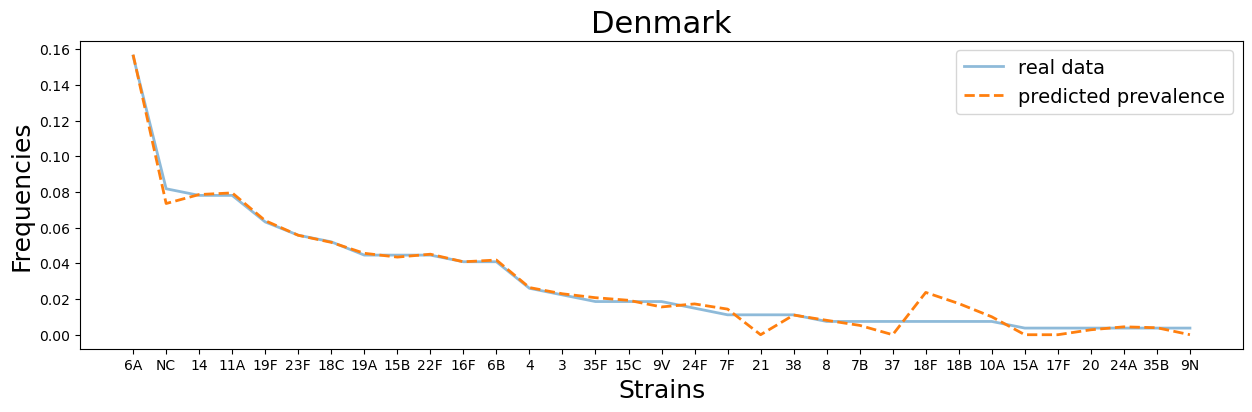

In [10]:
#FINAL TEST by data plot
range_strain = np.linspace(0, strain_number - 1, strain_number)
tick_label = np.array(Denmark.strain)

fig = plt.figure(figsize = (15, 4))
plt.plot(range_strain, Denmark_cases, '-', linewidth = 2, alpha =.5, label = 'real data')
plt.plot(range_strain, solution, '--', linewidth = 2, label = 'predicted prevalence')

plt.xlabel('Strains', fontsize = 18)
plt.ylabel('Frequencies', fontsize = 18)

plt.title('Denmark', fontsize = 22)

plt.xticks(range_strain, labels = tick_label)
plt.legend(fontsize = 14)
plt.show()

### Appendix: Test the equilibrium of dynamics and its stability

0.02656241731701966


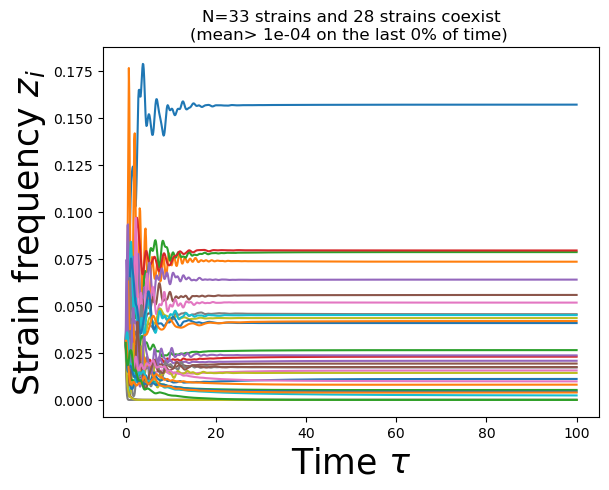

In [12]:
# compute the equilibrium of predicted model
one = np.ones(strain_number) #vector of all ones
result, ax = plot_dynamics(T = 100, mu = 10.23, A = Denmark_alpha, z0 = u0)

mu, A, fit, resultat, nc = simu(T = 50, mu = 10.23, A = Denmark_alpha, z0 = u0)
error = np.linalg.norm(resultat.y[:,-1] - Denmark_cases)
print(error)

In [8]:
# test stable equilibrium?

# test the equilibrium of predicted model
RHS = (np.matmul(lambd, solution) - np.matmul(solution.T, np.matmul(lambd, solution)))*solution
error = np.linalg.norm(RHS)
print(error)

#compute error between observation data and equilibrium of predicted model

#compute Jacobian matrix with the equilibrium
jac = jacobian_func(lambd, solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

2.643961486421888e-05
-0.05027962144695612


In [9]:
coexist_index = [i for i in range(0, 33) if solution[i] >= 1e-4]
print(coexist_index, len(coexist_index)) #len = 28

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 29, 30, 31] 28


In [11]:
sub_lambda = np.zeros((28, 28))
for i in range (0, 28):
    big_index_i = coexist_index[i]
    for j in range (0, 28):
        big_index_j = coexist_index[j]
        
        sub_lambda[i, j] = lambd[big_index_i, big_index_j]

In [12]:
coexist_solution = [i for i in solution if i >= 1e-4]

In [13]:
#compute Jacobian matrix with the equilibrium
sub_jac = jacobian_func(sub_lambda, coexist_solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(sub_jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

-0.050178884789034636
